### Import modules and verify they work? 

In [61]:
# general python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import numpy as np
import os
from pathlib import Path
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

In [62]:
# general eWC
import ewatercycle
import ewatercycle.models

In [4]:
# pip install ewatercycle-HBV==1.5.2

In [5]:
# pip install HBV==1.0.1

In [20]:
# for local mode
from typing import Type
from ewatercycle.base.model import LocalModel
from ewatercycle_HBV.model import HBVMethods # Use custom forcing instead
from HBV import HBV as HBV_bmi
from bmipy import Bmi

class LocalModelHBV(LocalModel, HBVMethods):
    """The HBV eWaterCycle model, with the local BMI."""
    bmi_class: Type[Bmi] = HBV_bmi

In [21]:
LocalModelHBV

__main__.LocalModelHBV

#### set up paths

In [22]:
path = Path.cwd()
forcing_path = path / "Forcing"
forcing_path

PosixPath('/home/davidhaasnoot/eWaterCycle-WSL-WIP/Forcing')

#### add parameter info

In [52]:
## Array of initial storage terms - we keep these constant for now 
##              Si,  Su, Sf, Ss
s_0 = np.array([0,  100,  0,  5])

## Array of parameters min/max bounds as a reference
##                      Imax,  Ce,  Sumax, beta,  Pmax,  T_lag,   Kf,   Ks
p_min_initial= np.array([0,   0.2,  40,    .5,   .001,   1,     .01,  .0001])
p_max_initial = np.array([8,    1,  800,   4,    .3,     10,    .1,   .01])
p_names = ["$I_{max}$",  "$C_e$",  "$Su_{max}$", "β",  "$P_{max}$",  "$T_{lag}$",   "$K_f$",   "$K_s$"]
S_names = ["Interception storage", "Unsaturated Rootzone Storage", "Fastflow storage", "Groundwater storage"]
param_names = ["Imax","Ce",  "Sumax", "beta",  "Pmax",  "Tlag",   "Kf",   "Ks"]

# set initial as mean of max,min
par_0 = (p_min_initial + p_max_initial)/2

In [53]:
experiment_start_date = "1997-08-01T00:00:00Z"
experiment_end_date = "2000-08-31T00:00:00Z"
HRU_id = 2479155
alpha = 1.2626

In [54]:
from ewatercycle_HBV.forcing import HBVForcing

In [55]:
test_forcing = HBVForcing(start_time = experiment_start_date,
                          end_time = experiment_end_date,
                          directory = forcing_path,
                          camels_file = f'test_forcing.txt',
                          test_data_bool=True
                          )

#### Can also run locally when developing - v0.1.1. here
```py
from ewatercycle.container import ContainerImage
LeakyBucket(forcing=forcing, bmi_image=ContainerImage("local_image:latest"))
```

In [56]:
from ewatercycle.container import ContainerImage
local_model = LocalModelHBV(forcing=test_forcing)

need to  add a local container to run

In [57]:
config_file, _ = local_model.setup(
            parameters=','.join([str(p) for p in par_0]),
            initial_storage=','.join([str(s) for s in s_0]),
           )

In [58]:
local_model.initialize(config_file)

In [63]:
ds = xr.open_dataset(forcing_path / local_model.forcing.pr)

In [64]:
Q_m = []
time = []
while local_model.time < local_model.end_time:
    local_model.update()
    Q_m.append(local_model.get_value("Q_m"))
    time.append(local_model.time_as_datetime.date())

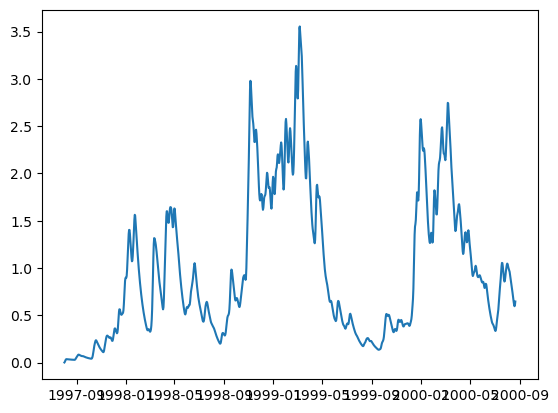

In [65]:
plt.plot(time[:-10], Q_m[:-10])

In [66]:
local_model.finalize()

In [67]:
print(local_model)

parameter_set=None forcing=HBVForcing(start_time='1997-08-01T00:00:00Z', end_time='2000-08-31T00:00:00Z', directory=PosixPath('/home/davidhaasnoot/eWaterCycle-WSL-WIP/Forcing'), shape=None, camels_file='test_forcing.txt', pr='HBV_forcing_2024-03-18 09_17.nc', pev='HBV_forcing_2024-03-18 09_17.nc', alpha=1.26, test_data_bool=True)


# Containerised

In [68]:
from ewatercycle.models import HBV

In [69]:
image_link = "ghcr.io/daafip/hbv-bmi-grpc4bmi:v1.3.2"

In [70]:
from ewatercycle.container import ContainerImage
model = HBV(forcing=test_forcing,bmi_image=ContainerImage(image_link))

In [71]:
config_file, _ = model.setup(
            parameters=','.join([str(p) for p in par_0]),
    initial_storage=','.join([str(s) for s in s_0]),
           )

In [72]:
model.initialize(config_file)

In [73]:
Q_m = []
time = []
while model.time < model.end_time:
    model.update()
    Q_m.append(model.get_value("Q"))
    time.append(pd.Timestamp(model.time_as_datetime.date()))

In [74]:
model.finalize()

In [75]:
df = pd.DataFrame(data=Q_m,columns=["Modeled discharge"],index=time)

In [76]:
Q_m_in_ref = np.loadtxt(r"Observations/Q_m_out_ref.txt")

In [82]:
df["Modeled discharge"].values - Q_m_in_ref[:-1]

array([-0.00088206, -0.0035307 , -0.00655039, ...,  0.00967489,
        0.00786314,  0.00894746])

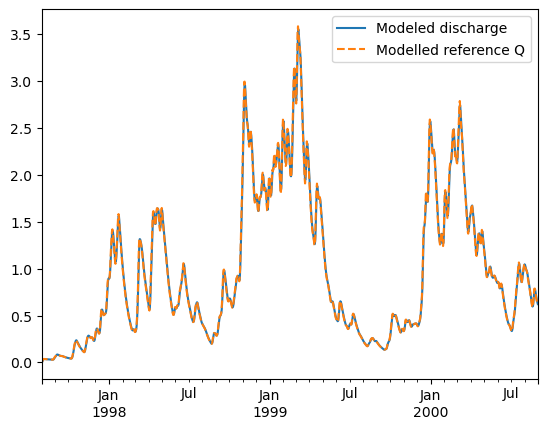

In [83]:
fig, ax = plt.subplots(1,1)
df.plot(ax=ax,label="Modeled discharge HBV-bmi")
ax.plot(df.index, Q_m_in_ref[:-1],ls="--",label="Modelled reference Q");
# ds["Q"].plot(ax=ax,lw=0,marker="*",ms=2.5,zorder=-1,label="Observations")
ax.legend(bbox_to_anchor=(1,1))